 # Quick comparison of PCN and CPCN on MNIST

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pydove as dv

import numpy as np
import torch
import torchvision

from tqdm.notebook import tqdm

from cpcn.linear import LinearCPCNetwork
from cpcn.pcn import PCNetwork
from cpcn.util import make_onehot, evaluate

 ## Choose device

In [2]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

 ## Load dataset

In [3]:
trainset = torchvision.datasets.MNIST("data/", train=True, download=True)
testset = torchvision.datasets.MNIST("data/", train=False, download=True)

# split out a validation set and normalize
mu = 33.3184
sigma = 78.5675
normalized = (trainset.data - mu) / sigma
train_size = 5_000
validation_size = 1_000
dataset = {
    "train": (normalized[:train_size], trainset.targets[:train_size]),
    "validation": (normalized[-validation_size:], trainset.targets[-validation_size:]),
    "test": ((testset.data - mu) / sigma, testset.targets),
}

# flatten images; make labels one hot
for key, item in dataset.items():
    dataset[key] = (
        item[0].reshape(item[0].shape[0], -1).to(device),
        make_onehot(item[1]).to(device),
    )

 ## Train PCN

 ### Setup loaders

In [4]:
# for reproducibility
torch.manual_seed(123)

batch_size = 128

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(*dataset["train"]),
    batch_size=batch_size,
    shuffle=True,
)
validation_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(*dataset["validation"]), batch_size=batch_size,
)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(*dataset["test"]), batch_size=batch_size,
)

 ### Setup network

In [5]:
n_epochs = 50
dims = [784, 50, 20, 10]
it_inference = 50
lr_inference = 0.1

torch.manual_seed(123)

net = PCNetwork(
    dims,
    activation=lambda _: _,
    lr_inference=lr_inference,
    it_inference=it_inference,
    variances=1.0,
)
net = net.to(device)

 ### Run the actual training

In [6]:
losses = np.zeros(n_epochs)
accuracies = np.zeros(n_epochs)
train_losses = np.zeros((n_epochs, len(train_loader)))

optimizer = torch.optim.Adam(net.slow_parameters(), lr=0.001)

# train a linear classifier on the output from the last hidden layer
classifier = torch.nn.Sequential(torch.nn.Linear(*dims[-2:]))
classifier_optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
classifier_criterion = torch.nn.MSELoss()

# pbar = tqdm(range(n_epochs), desc="val: loss ?.??? acc ?.??")
pbar = tqdm(range(n_epochs))
for epoch in pbar:
    # train
    for i, (x, y) in enumerate(train_loader):
        net.forward_constrained(x, y)

        classifier_optimizer.zero_grad()
        optimizer.zero_grad()

        loss = net.loss()
        loss.backward()

        # propagate through the classifier
        classifier_out = classifier(net.z[-2])
        classifier_loss = classifier_criterion(classifier_out, y)
        classifier_loss.backward()

        optimizer.step()
        classifier_optimizer.step()

        train_losses[epoch, i] = loss.item()

    # evaluate
    losses[epoch], accuracies[epoch] = evaluate(
        net, validation_loader, classifier=classifier
    )
    # pbar.set_description(f"val: loss {losses[epoch]:.2g} acc {accuracies[epoch]:.2f}")
    pbar.set_postfix(
        {"val_loss": f"{losses[epoch]:.2g}", "val_acc": f"{accuracies[epoch]:.2f}"}
    )

train_losses = np.sum(train_losses, axis=1) / len(train_loader.dataset)

  0%|          | 0/50 [00:00<?, ?it/s]

 ## Show learning curves

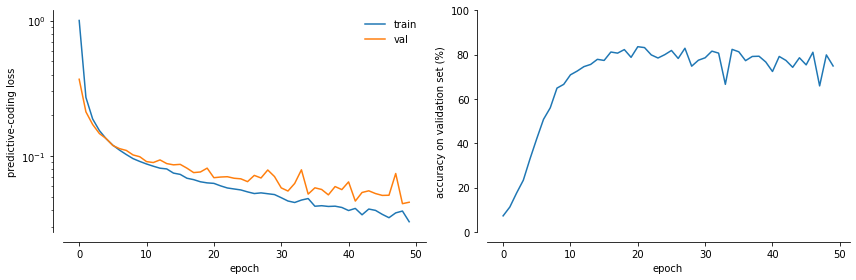

In [7]:
with dv.FigureManager(1, 2) as (_, (ax1, ax2)):
    ax1.semilogy(train_losses, label="train")
    ax1.semilogy(losses, label="val")
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("predictive-coding loss")
    ax1.legend(frameon=False)

    ax2.plot(100 * accuracies)
    ax2.set_xlabel("epoch")
    ax2.set_ylabel("accuracy on validation set (%)")
    ax2.set_ylim(0, 100)

 ## Train CPCN

In [8]:
z_it = 100
z_lr = 0.05

torch.manual_seed(123)

# match the PCN network
g_a = 0.5 * np.ones(len(dims) - 2)
g_a[-1] *= 2

g_b = 0.5 * np.ones(len(dims) - 2)
g_b[0] *= 2

cpcn_net = LinearCPCNetwork(
    dims, z_lr=z_lr, z_it=z_it, g_a=g_a, g_b=g_b, c_m=0, l_s=g_b
)
cpcn_net = cpcn_net.to(device)

In [9]:
cpcn_losses = np.zeros(n_epochs)
cpcn_accuracies = np.zeros(n_epochs)
cpcn_train_losses = np.zeros((n_epochs, len(train_loader)))

cpcn_optimizer = torch.optim.Adam(cpcn_net.slow_parameters(), lr=0.001)

# train a linear classifier on the output from the last hidden layer
cpcn_classifier = torch.nn.Sequential(torch.nn.Linear(*dims[-2:]))
cpcn_classifier_optimizer = torch.optim.Adam(cpcn_classifier.parameters(), lr=0.001)
cpcn_classifier_criterion = torch.nn.MSELoss()

# pbar = tqdm(range(n_epochs), desc="val: loss ?.??? acc ?.??")
pbar = tqdm(range(n_epochs))
for epoch in pbar:
    # train
    for i, (x, y) in enumerate(train_loader):
        cpcn_net.forward_constrained(x, y)
        loss = cpcn_net.loss()

        cpcn_net.calculate_weight_grad()
        cpcn_classifier_optimizer.zero_grad()

        # propagate through the classifier
        cpcn_classifier_out = cpcn_classifier(cpcn_net.z[-2])
        cpcn_classifier_loss = cpcn_classifier_criterion(cpcn_classifier_out, y)
        cpcn_classifier_loss.backward()

        cpcn_optimizer.step()
        cpcn_classifier_optimizer.step()

        cpcn_train_losses[epoch, i] = loss.item()

    # evaluate
    cpcn_losses[epoch], cpcn_accuracies[epoch] = evaluate(
        cpcn_net, validation_loader, classifier=cpcn_classifier
    )
    # pbar.set_description(f"val: loss {losses[epoch]:.2g} acc {accuracies[epoch]:.2f}")
    pbar.set_postfix(
        {
            "val_loss": f"{cpcn_losses[epoch]:.2g}",
            "val_acc": f"{cpcn_accuracies[epoch]:.2f}",
        }
    )

cpcn_train_losses = np.sum(cpcn_train_losses, axis=1) / len(train_loader.dataset)

  0%|          | 0/50 [00:00<?, ?it/s]

 ## Show CPCN learning curves

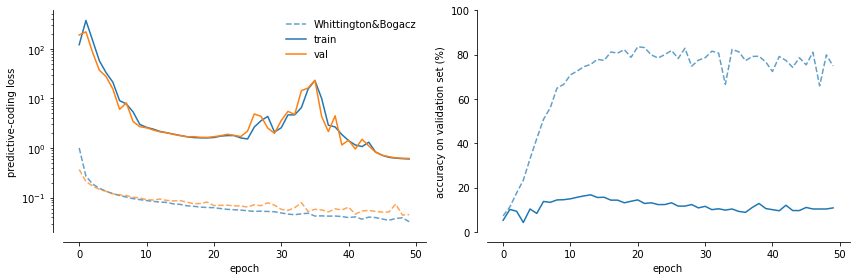

In [10]:
with dv.FigureManager(1, 2) as (_, (ax1, ax2)):
    ax1.semilogy(train_losses, c="C0", ls="--", alpha=0.7, label="Whittington&Bogacz")
    ax1.semilogy(losses, c="C1", ls="--", alpha=0.7)

    ax1.semilogy(cpcn_train_losses, c="C0", label="train")
    ax1.semilogy(cpcn_losses, c="C1", label="val")
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("predictive-coding loss")
    ax1.legend(frameon=False)

    ax2.plot(100 * accuracies, c="C0", ls="--", alpha=0.7, label="Whittington&Bogacz")
    ax2.plot(100 * cpcn_accuracies, c="C0")
    ax2.set_xlabel("epoch")
    ax2.set_ylabel("accuracy on validation set (%)")
    ax2.set_ylim(0, 100)